# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.524459,False,2.894592
1,0.597564,True,5.522022
2,-0.918363,False,-1.742012
3,-0.144220,False,-0.553316
4,0.277026,True,6.652711
...,...,...,...
995,0.275157,False,-0.155439
996,-0.490586,True,2.751520
997,0.386001,False,1.374444
998,0.623935,True,6.125341


<Axes: xlabel='v0'>

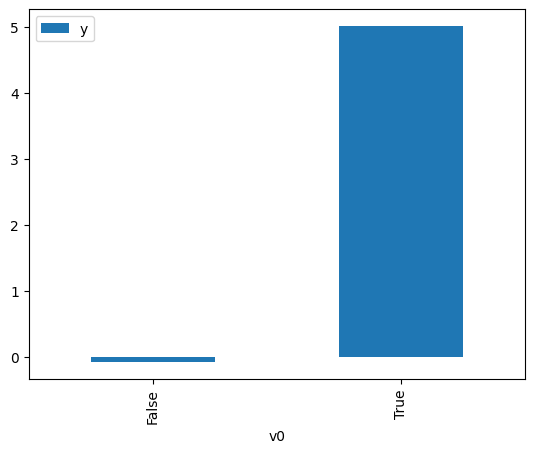

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

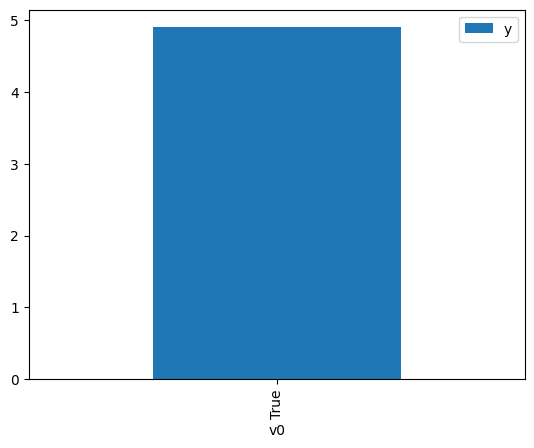

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.686850,False,1.336979,0.307573,3.251263
1,-0.968684,False,-2.292953,0.719606,1.389649
2,0.208372,False,1.270343,0.424444,2.356022
3,-0.039039,False,0.876932,0.489394,2.043342
4,1.195703,False,1.539124,0.205771,4.859778
...,...,...,...,...,...
995,1.606665,False,2.004791,0.143562,6.965625
996,1.336141,False,2.721816,0.182515,5.479001
997,-0.143527,False,-0.421825,0.517062,1.934005
998,-0.399153,False,-1.246800,0.583973,1.712409


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.486018,True,5.731617,0.645362,1.549517
1,-2.019900,True,1.438117,0.113423,8.816575
2,0.779625,True,5.351522,0.712956,1.402611
3,1.599964,True,9.187401,0.855563,1.168821
4,-1.085253,True,3.149118,0.256163,3.903769
...,...,...,...,...,...
995,1.028011,True,6.188327,0.763677,1.309455
996,-0.070812,True,6.911912,0.502191,1.991272
997,-1.238410,True,1.942119,0.226483,4.415339
998,0.120633,True,6.926872,0.552703,1.809290


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                          1.047e+04
Date:                Tue, 26 Aug 2025   Prob (F-statistic):                        0.00
Time:                        20:27:55   Log-Likelihood:                         -1375.7
No. Observations:                1000   AIC:                                      2755.
Df Residuals:                     998   BIC:                                      2765.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5378      0.031     48.913      0.000       1.476       1.600
x2             5.0199      0.044    113.339      0.000       4.933       5.107
==============================================================================
Omnibus:                        3.734   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.814
Skew:                          -0.092   Prob(JB):                        0.149
Kurtosis:                       3.240   Cond. No.                         1.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""